## Домашнее задание

1. Необходимо подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples для обучения модели на сегментацию губ
2. Обучить модель на выбор из [segmentation_models_pytorch](https://segmentation-modelspytorch.readthedocs.io/en/latest/index.html)

In [1]:
from segmentation_models_pytorch import Unet
import os, pandas as pd
import cv2, numpy as np

#определим директории нашего датасета
curdir = os.getcwd()

fld_img = os.path.join(curdir,'720p')
fld_msk = os.path.join(curdir,'mask')

#посмотрим данные
dataset_data = pd.read_csv('list.csv')
dataset_data.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [2]:
#возьмем 1000 изображений в случайном порядке
dataset_data = dataset_data.sample(frac=1000/len(dataset_data), random_state = 20)
dataset_data.reset_index(inplace=True, drop=True)

#меняем названия одного из столбцов для удобства рабботы
cols = list(dataset_data.columns)
cols[-1] = 'mask_f'
dataset_data.columns = cols

dataset_imgs = dataset_data.filename
dataset_masks = dataset_data.mask_f

In [3]:
#создадим numpy-массивы для хранения картинок - 800 в обучающей выборке и 200 в тестовой.
#Размер картинок будем приводить к 512x288 (исходники - 1280x720). Размеры входных
#изображений и масок равны (меняются местами)
imgs_train = np.zeros((800,3,288,512))
imgs_test = np.zeros((200,3,288,512))
masks_train = np.zeros((800,3,288,512))
masks_test = np.zeros((200,3,288,512))

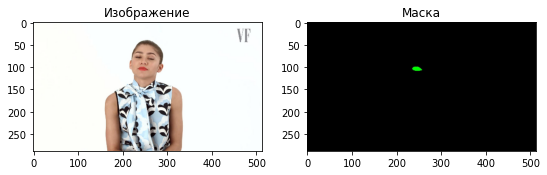

In [4]:
#создаем обучающую и тестовую выборки
#все изображения пронормируем путем деления на 255
import matplotlib.pyplot as plt

for i in range(800):
    xxx = cv2.imread(os.path.join(fld_img,dataset_imgs[i]))
    xxx = cv2.cvtColor(xxx, cv2.COLOR_BGR2RGB)
    xxx = cv2.resize(xxx, (512,288))
    for j in range(3):
        imgs_train[i,j,:,:] = xxx[:,:,j]/255
    
    yyy = cv2.imread(os.path.join(fld_msk,dataset_masks[i]))
    yyy = cv2.cvtColor(yyy, cv2.COLOR_BGR2RGB)
    yyy = cv2.resize(yyy, (512,288))
    for j in range(3):
        masks_train[i,j,:,:] = yyy[:,:,j]/255
    
    #выведем, для примера, 100-ю картинку
    if i==100:
        fig, axs = plt.subplots(1, 2, figsize=(9, 3))
        axs[0].imshow(xxx)
        axs[0].set_title('Изображение')
        axs[1].imshow(yyy)
        axs[1].set_title('Маска')
        

for i in range(800,1000):
    xxx = cv2.imread(os.path.join(fld_img,dataset_imgs[i]))
    xxx = cv2.cvtColor(xxx, cv2.COLOR_BGR2RGB)
    xxx = cv2.resize(xxx, (512,288))
    for j in range(3):
        imgs_test[i-800,j,:,:] = xxx[:,:,j]/255
    
    yyy = cv2.imread(os.path.join(fld_msk,dataset_masks[i]))
    yyy = cv2.cvtColor(yyy, cv2.COLOR_BGR2RGB)
    yyy = cv2.resize(yyy, (512,288))
    for j in range(3):
        masks_test[i-800,j,:,:] = yyy[:,:,j]/255

In [5]:
#создаем сеть UNet c дефолтными настройками (глубина=5, веса получены на наборе ImageNet)
net = Unet()

import torch.nn as nn
import torch.optim as opt
import torch

opt=opt.SGD(net.parameters(), lr=0.001, momentum=0.9) #оптимизатор
criterion=nn.CrossEntropyLoss() #функция потерь (отриц. логарифм правдоподобия)

In [6]:
#запустим процесс обучения
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 32
smpls_train = imgs_train.shape[0]
batches = int(np.ceil(smpls_train/batch_size))

#переводим выборку в тензоры
imgs_train = torch.Tensor(imgs_train)
imgs_test = torch.Tensor(imgs_test)
masks_train = torch.Tensor(masks_train)
masks_test = torch.Tensor(masks_test)

for epoch in tqdm(range(10)):  
    running_loss = 0.0
    for i in range(batches):
        if i+1 != batches:
            inputs = imgs_train[i*batch_size:(i+1)*batch_size, :]
            labels = masks_train[i*batch_size:(i+1)*batch_size, :]
        else:
            inputs1 = imgs_train[i*batch_size:smpls_train, :]
            labels1 = masks_train[i*batch_size:smpls_train, :]
                    
            resid = batch_size - (smpls_train - i*batch_size)
                    
            inputs2 = imgs_train[0:resid, :]
            labels2 = masks_train[0:resid, :]
                    
            inputs = torch.cat((inputs1,inputs2))
            labels = torch.cat((labels1,labels2))
                    
            del inputs1, labels1, inputs2, labels2

            # обнуляем градиент
            opt.zero_grad()

            outputs = net(inputs)
            loss = net.criterion(outputs, labels)
            loss.backward()
            net.opt.step()

            # выводим статистику о процессе обучения
            running_loss += loss.item()
            if i % 5 == 0:    # печатаем каждые 5 mini-batches
                print('[%d, %5d] loss: %.3f' %
                     (epoch + 1, i + 1, running_loss / (batch_size * 5))) # откуда 2000?
                running_loss = 0.0
                
            
        
        #вычисление ошибки на тестовом наборе данных
        y_pred = net(imgs_test)
        loss_test = net.criterion(y_pred, masks_test).item()

  0%|                                                                                           | 0/10 [26:29<?, ?it/s]


RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 117964800 bytes.